# Part 1. Data modelling [SQL]

query in `queries.sql`

# Part 2. Data analysis and visualisation
Create a report in which you will include charts and briefly present your line of thinking. Write down assumptions you made, describe your methodology, e.g. how you filtered data etc. The report should be easy to understand for non-technical people. Name your report name_surname_analysis.pdf and include it as part of your final solution.

Don’t make any assumptions about data quality. The data may contain some erroneous samples or corrupted values.

1.	Generate a histogram showing the actual delivery length with 1 minute granularity (rounded up).
2.	Generate a histogram showing prediction error (difference between planned and actual delivery times).
3.	We received insight from our drivers that delivering in one of the sectors is significantly longer than in other sectors. Generate a chart to visualise this hypothesis.
4.	Play with the data by grouping, aggregating and remodelling it. Are you able to find any correlations or trends that could be valuable for prediction quality improvement? Describe briefly your findings and visualise them on charts.


In [106]:
import seaborn as sns
import matplotlib.pyplot as plt

# Styl wykresów
sns.set_style("whitegrid")

# Paleta kolorów
custom_palette = [ "#7F187F", "#C8A2C8", "#5D5E60", "#B1BA1C", "#E41A1C", "#FFA500"]

sns.set_palette(custom_palette)

# Kontekst wykresów
sns.set_context("notebook", font_scale=1.2)

# Ustawienia czcionek i osi
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': 'Arial',
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'legend.fontsize': 11,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10
})


In [107]:
from sqlalchemy import create_engine
import pandas as pd
import numpy as np

# databese parameters 
username = 'root'
password = 'my-secret-pw'
host = 'localhost'
port = '3306'
database = 'droptime'

# creating engine
engine = create_engine(f"mysql+pymysql://{username}:{password}@{host}:{port}/{database}")

# query example
query = "SELECT * FROM orders LIMIT 10;"

# query to pandas dataframe
df = pd.read_sql(query, engine)
df.head()

,order_id,customer_id,sector_id,planned_delivery_duration
0,0,116,1,176
1,1,160,1,169
2,2,94,2,177
3,3,165,3,176
4,4,78,2,177


## 1. Generate a histogram showing the actual delivery length with 1 minute granularity (rounded up).

How to connect to database and simple query example

In [108]:
# query example
query = """
WITH delivery_durations as (
	SELECT *, TIMESTAMPDIFF(SECOND, segment_start_time, segment_end_time) AS delivery_duration_seconds
	FROM droptime.route_segments rs 
	WHERE rs.segment_type = 'STOP' and rs.order_id is not null and TIMESTAMPDIFF(SECOND, segment_start_time, segment_end_time) > 0
), statistics as (
	SELECT
		AVG(delivery_duration_seconds) AS Mean,
    	STDDEV(delivery_duration_seconds) AS StdDev
    FROM delivery_durations
), filtered_data as (
	SELECT *
	FROM delivery_durations dd
	CROSS JOIN statistics s
	WHERE dd.delivery_duration_seconds BETWEEN (s.Mean - 2 * s.StdDev) AND (s.Mean + 2 * s.StdDev)
), with_counts as (
	SELECT *, 
		ROW_NUMBER() OVER (PARTITION BY order_id ORDER BY delivery_duration_seconds) as rn
	FROM filtered_data
)
SELECT * 
FROM with_counts
WHERE rn = 1;
 """

# query to pandas dataframe
df = pd.read_sql(query, engine)
df.head()

,segment_id,driver_id,segment_type,order_id,segment_start_time,segment_end_time,delivery_duration_seconds,Mean,StdDev,rn
0,2738,3,STOP,0,2024-02-04 08:34:03,2024-02-04 08:39:12,309,342.4974,1525.145008,1
1,2751,1,STOP,1,2024-02-02 08:47:30,2024-02-02 08:48:39,69,342.4974,1525.145008,1
2,1137,3,STOP,2,2024-02-15 07:11:54,2024-02-15 07:15:15,201,342.4974,1525.145008,1
3,2365,1,STOP,3,2024-02-19 03:46:50,2024-02-19 03:48:22,92,342.4974,1525.145008,1
4,441,1,STOP,4,2024-02-21 14:43:38,2024-02-21 14:44:59,81,342.4974,1525.145008,1


In [109]:
df["duration_in_min"] = np.ceil(df["delivery_duration_seconds"] / 60).astype(int)
df

,segment_id,driver_id,segment_type,order_id,segment_start_time,segment_end_time,delivery_duration_seconds,Mean,StdDev,rn,duration_in_min
0,2738,3,STOP,0,2024-02-04 08:34:03,2024-02-04 08:39:12,309,342.4974,1525.145008,1,6
1,2751,1,STOP,1,2024-02-02 08:47:30,2024-02-02 08:48:39,69,342.4974,1525.145008,1,2
2,1137,3,STOP,2,2024-02-15 07:11:54,2024-02-15 07:15:15,201,342.4974,1525.145008,1,4
3,2365,1,STOP,3,2024-02-19 03:46:50,2024-02-19 03:48:22,92,342.4974,1525.145008,1,2
4,441,1,STOP,4,2024-02-21 14:43:38,2024-02-21 14:44:59,81,342.4974,1525.145008,1,2
...,...,...,...,...,...,...,...,...,...,...,...
2082,3410,4,STOP,2235,2024-02-13 03:05:22,2024-02-13 03:11:20,358,342.4974,1525.145008,1,6
2083,3390,3,STOP,2236,2024-02-25 14:13:17,2024-02-25 14:17:29,252,342.4974,1525.145008,1,5
2084,2824,1,STOP,2237,2024-02-24 09:14:12,2024-02-24 09:15:26,74,342.4974,1525.145008,1,2
2085,974,2,STOP,2238,2024-02-12 15:59:57,2024-02-12 16:02:01,124,342.4974,1525.145008,1,3


<Axes: ylabel='Frequency'>

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

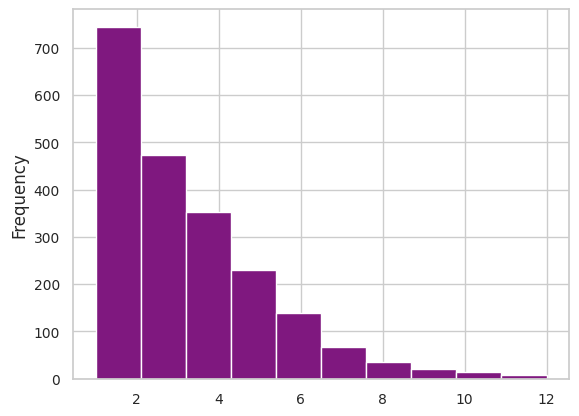

In [110]:
df["duration_in_min"].plot(kind="hist")

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

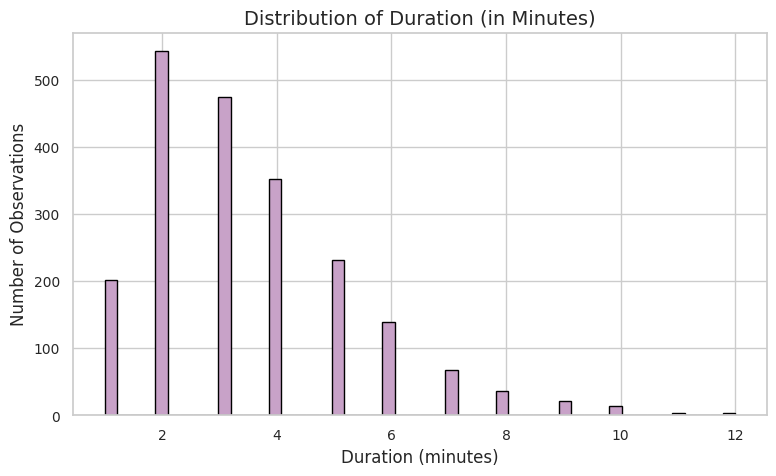

In [113]:
plt.figure(figsize=(8, 5))
df["duration_in_min"].plot(
    kind="hist",
    bins=50,
    color=custom_palette[1],
    edgecolor='black',
)

plt.title('Distribution of Duration (in Minutes)', fontsize=14)
plt.xlabel('Duration (minutes)', fontsize=12)
plt.ylabel('Number of Observations', fontsize=12)

plt.grid(True)
plt.tight_layout()
plt.show()

## 2.	Generate a histogram showing prediction error (difference between planned and actual delivery times).

* calculate delivery times
    * Problem how to calculate one delivery?
        * in data we have for example stops without order id, or multiple stops, drives one after the other => Solution: Assumption that one delivery is time of: segment_end_time of STOP segment type with order_id - segment_start_time of nearest DRIVE segment type for this driver, If there are multiple stops or drives its poropably not realated with this delivery
* calculate errors
* plot histogram

In [114]:
# calculate delivery times
# calculate errors
# plot histogram


# query example
query = """
WITH delivery_durations as (
	SELECT *, TIMESTAMPDIFF(SECOND, segment_start_time, segment_end_time) AS delivery_duration_seconds
	FROM droptime.route_segments rs 
	WHERE rs.segment_type = 'STOP' and rs.order_id is not null and TIMESTAMPDIFF(SECOND, segment_start_time, segment_end_time) > 0
), statistics as (
	SELECT
		AVG(delivery_duration_seconds) AS Mean,
    	STDDEV(delivery_duration_seconds) AS StdDev
    FROM delivery_durations
), filtered_data as (
	SELECT *
	FROM delivery_durations dd
	CROSS JOIN statistics s
	WHERE dd.delivery_duration_seconds BETWEEN (s.Mean - 2 * s.StdDev) AND (s.Mean + 2 * s.StdDev)
), with_counts as (
	SELECT *, 
		ROW_NUMBER() OVER (PARTITION BY order_id ORDER BY delivery_duration_seconds) as rn
	FROM filtered_data
), dedup as (
	SELECT *		 
	FROM with_counts
	WHERE rn = 1
) 
SELECT *, d.delivery_duration_seconds - o.planned_delivery_duration as error
FROM dedup d
LEFT JOIN droptime.orders o ON d.order_id = o.order_id
 """

# query to pandas dataframe
df = pd.read_sql(query, engine)
df.head()

,segment_id,driver_id,segment_type,order_id,segment_start_time,segment_end_time,delivery_duration_seconds,Mean,StdDev,rn,order_id,customer_id,sector_id,planned_delivery_duration,error
0,2738,3,STOP,0,2024-02-04 08:34:03,2024-02-04 08:39:12,309,342.4974,1525.145008,1,0,116,1,176,133
1,2751,1,STOP,1,2024-02-02 08:47:30,2024-02-02 08:48:39,69,342.4974,1525.145008,1,1,160,1,169,-100
2,1137,3,STOP,2,2024-02-15 07:11:54,2024-02-15 07:15:15,201,342.4974,1525.145008,1,2,94,2,177,24
3,2365,1,STOP,3,2024-02-19 03:46:50,2024-02-19 03:48:22,92,342.4974,1525.145008,1,3,165,3,176,-84
4,441,1,STOP,4,2024-02-21 14:43:38,2024-02-21 14:44:59,81,342.4974,1525.145008,1,4,78,2,177,-96


<Axes: ylabel='Frequency'>

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

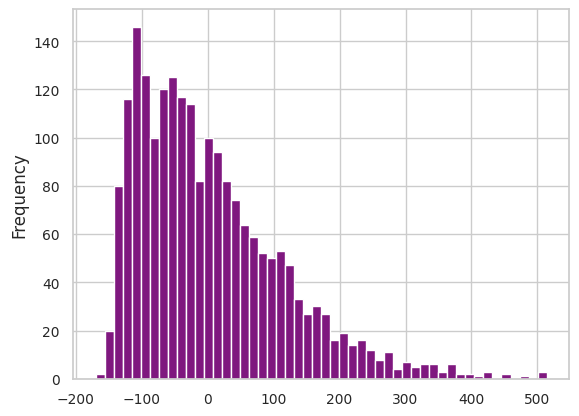

In [43]:
df["error"].plot(kind="hist", bins=50)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

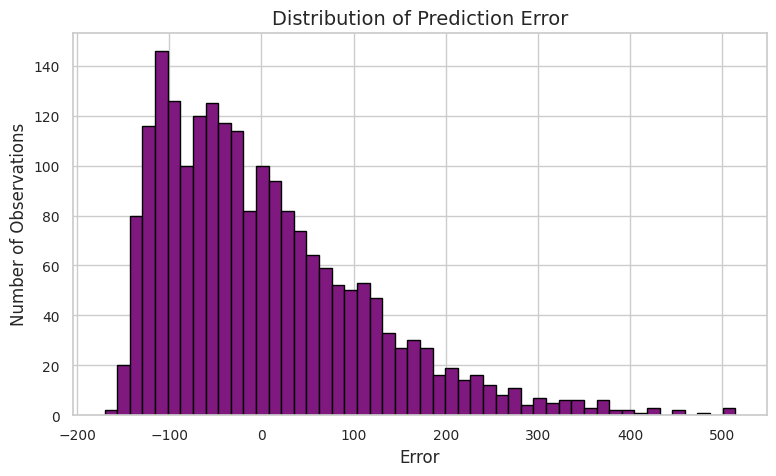

In [118]:
plt.figure(figsize=(8, 5))
df["error"].plot(
    kind="hist",
    bins=50,
    color=custom_palette[0],
    edgecolor='black',
)

plt.title('Distribution of Prediction Error', fontsize=14)
plt.xlabel('Error', fontsize=12)
plt.ylabel('Number of Observations', fontsize=12)

plt.grid(True)
plt.tight_layout()
plt.show()

## 3.	We received insight from our drivers that delivering in one of the sectors is significantly longer than in other sectors. Generate a chart to visualise this hypothesis.

In [119]:
# query example
query = """
WITH delivery_durations as (
	SELECT *, TIMESTAMPDIFF(SECOND, segment_start_time, segment_end_time) AS delivery_duration_seconds
	FROM droptime.route_segments rs 
	WHERE rs.segment_type = 'STOP' and rs.order_id is not null and TIMESTAMPDIFF(SECOND, segment_start_time, segment_end_time) > 0
), statistics as (
	SELECT
		AVG(delivery_duration_seconds) AS Mean,
    	STDDEV(delivery_duration_seconds) AS StdDev
    FROM delivery_durations
), filtered_data as (
	SELECT *
	FROM delivery_durations dd
	CROSS JOIN statistics s
	WHERE dd.delivery_duration_seconds BETWEEN (s.Mean - 2 * s.StdDev) AND (s.Mean + 2 * s.StdDev)
), with_counts as (
	SELECT *, 
		ROW_NUMBER() OVER (PARTITION BY order_id ORDER BY delivery_duration_seconds) as rn
	FROM filtered_data
), dedup as (
	SELECT *		 
	FROM with_counts
	WHERE rn = 1
) 
SELECT *, d.delivery_duration_seconds - o.planned_delivery_duration as error
FROM dedup d
LEFT JOIN droptime.orders o ON d.order_id = o.order_id
 """

# query to pandas dataframe
df = pd.read_sql(query, engine)
df.head()

,segment_id,driver_id,segment_type,order_id,segment_start_time,segment_end_time,delivery_duration_seconds,Mean,StdDev,rn,order_id,customer_id,sector_id,planned_delivery_duration,error
0,2738,3,STOP,0,2024-02-04 08:34:03,2024-02-04 08:39:12,309,342.4974,1525.145008,1,0,116,1,176,133
1,2751,1,STOP,1,2024-02-02 08:47:30,2024-02-02 08:48:39,69,342.4974,1525.145008,1,1,160,1,169,-100
2,1137,3,STOP,2,2024-02-15 07:11:54,2024-02-15 07:15:15,201,342.4974,1525.145008,1,2,94,2,177,24
3,2365,1,STOP,3,2024-02-19 03:46:50,2024-02-19 03:48:22,92,342.4974,1525.145008,1,3,165,3,176,-84
4,441,1,STOP,4,2024-02-21 14:43:38,2024-02-21 14:44:59,81,342.4974,1525.145008,1,4,78,2,177,-96


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

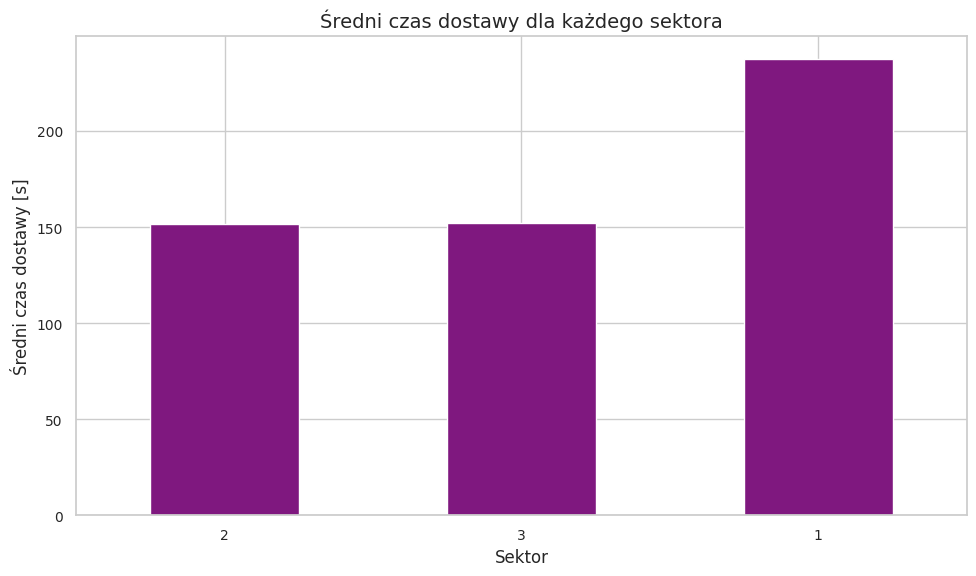

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt



# Grupowanie i obliczanie średniej
sector_means = df.groupby('sector_id')['delivery_duration_seconds'].mean().sort_values()

# Wykres słupkowy
plt.figure(figsize=(10, 6))
# sector_means.plot(kind='bar', color='skyblue', edgecolor='black')
sector_means.plot(kind='bar')
plt.xlabel('Sektor')
plt.ylabel('Średni czas dostawy [s]')
plt.title('Średni czas dostawy dla każdego sektora')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

<Axes: xlabel='sector_id', ylabel='delivery_duration_seconds'>

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

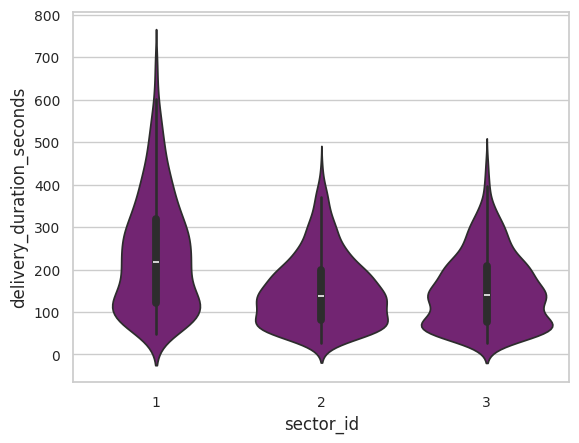

In [47]:
# import seaborn as sns
sns.violinplot(data=df, x='sector_id', y='delivery_duration_seconds')

/tmp/ipykernel_1401/1494571107.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_1401/1494571107.py:2: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  sns.violinplot(
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families w

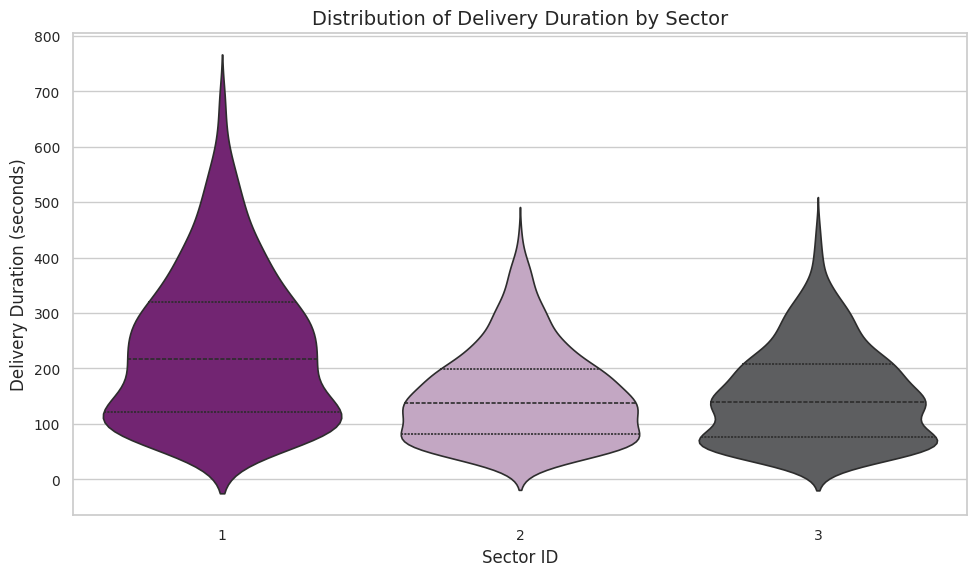

In [121]:
plt.figure(figsize=(10, 6))
sns.violinplot(
    data=df,
    x='sector_id',
    y='delivery_duration_seconds',
    palette=custom_palette,
    inner="quart",  # Dodanie wewnętrznego rozkładu (np. kwartyle)
    linewidth=1.2
)

plt.title('Distribution of Delivery Duration by Sector', fontsize=14)
plt.xlabel('Sector ID', fontsize=12)
plt.ylabel('Delivery Duration (seconds)', fontsize=12)

plt.tight_layout()
plt.show()

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

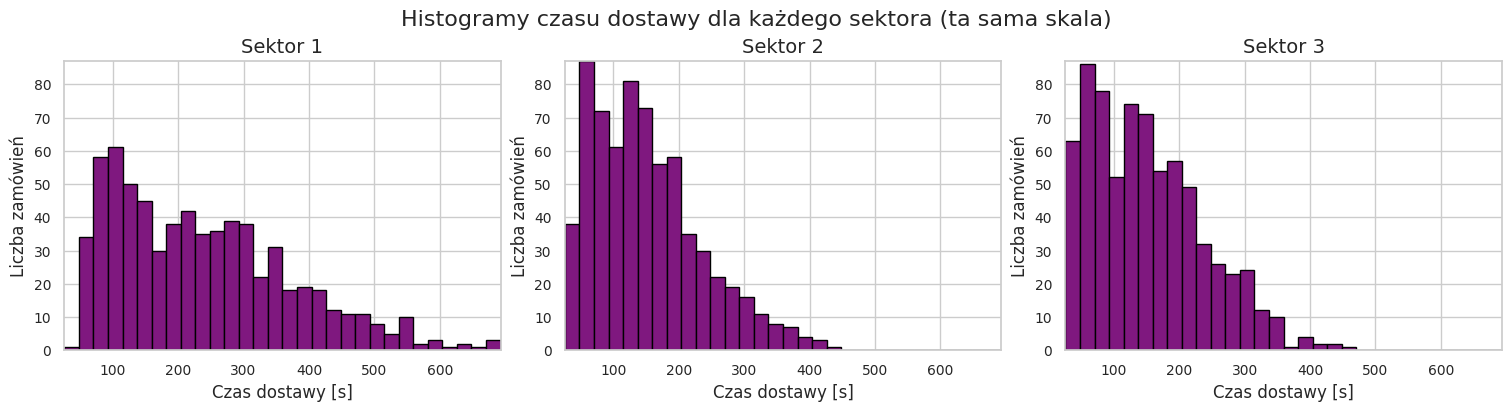

In [122]:
import pandas as pd
import matplotlib.pyplot as plt

# Załaduj dane – df z kolumnami: 'sector' (int), 'actual_delivery_duration' (czas w sekundach)

unique_sectors = df['sector_id'].unique()
n_sectors = len(unique_sectors)

cols = 3
rows = -(-n_sectors // cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4), constrained_layout=True)
axes = axes.flatten()

# Wspólny zakres dla osi X i Y
min_x = df['delivery_duration_seconds'].min()
max_x = df['delivery_duration_seconds'].max()

# Histogramy: najpierw oblicz maksymalną wartość liczby zamówień w jednym binie (dla Y)
max_y = 0
for sector in unique_sectors:
    counts, _ = np.histogram(df[df['sector_id'] == sector]['delivery_duration_seconds'], bins=30, range=(min_x, max_x))
    max_y = max(max_y, counts.max())

# Rysowanie histogramów z tymi samymi osiami
for i, sector in enumerate(sorted(unique_sectors)):
    sector_data = df[df['sector_id'] == sector]['delivery_duration_seconds']
    
    # axes[i].hist(sector_data, bins=30, range=(min_x, max_x), color='steelblue', edgecolor='black')
    axes[i].hist(sector_data, bins=30, range=(min_x, max_x), edgecolor='black')
    axes[i].set_title(f'Sektor {sector}')
    axes[i].set_xlabel('Czas dostawy [s]')
    axes[i].set_ylabel('Liczba zamówień')
    axes[i].set_xlim(min_x, max_x)
    axes[i].set_ylim(0, max_y)

# Ukryj puste osie
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('Histogramy czasu dostawy dla każdego sektora (ta sama skala)', fontsize=16)
plt.show()


## 4.	Play with the data by grouping, aggregating and remodelling it. Are you able to find any correlations or trends that could be valuable for prediction quality improvement? Describe briefly your findings and visualise them on charts.

In [123]:
query = """
WITH delivery_durations as (
	SELECT *, TIMESTAMPDIFF(SECOND, segment_start_time, segment_end_time) AS delivery_duration_seconds
	FROM droptime.route_segments rs 
	WHERE rs.segment_type = 'STOP' and rs.order_id is not null and TIMESTAMPDIFF(SECOND, segment_start_time, segment_end_time) > 0
), statistics as (
	SELECT
		AVG(delivery_duration_seconds) AS Mean,
    	STDDEV(delivery_duration_seconds) AS StdDev
    FROM delivery_durations
), filtered_data as (
	SELECT *
	FROM delivery_durations dd
	CROSS JOIN statistics s
	WHERE dd.delivery_duration_seconds BETWEEN (s.Mean - 2 * s.StdDev) AND (s.Mean + 2 * s.StdDev)
), with_counts as (
	SELECT *, 
		ROW_NUMBER() OVER (PARTITION BY order_id ORDER BY delivery_duration_seconds) as rn
	FROM filtered_data
), dedup as (
	SELECT *		 
	FROM with_counts
	WHERE rn = 1
), data_with_errors as (
	SELECT d.order_id, o.sector_id, o.planned_delivery_duration, d.driver_id, d.segment_start_time, d.segment_end_time, d.delivery_duration_seconds - o.planned_delivery_duration as error, d.delivery_duration_seconds
	FROM dedup d
	LEFT JOIN droptime.orders o ON d.order_id = o.order_id
) 
SELECT 
    o.order_id,
    o.delivery_duration_seconds,
    o.driver_id,
    o.segment_start_time,
    o.segment_end_time,
    SUM(op.quantity) AS total_quantity,
    SUM(op.quantity * p.weight) AS total_weight
FROM 
    data_with_errors o
JOIN 
    droptime.orders_products op ON o.order_id = op.order_id
JOIN 
    droptime.products p ON op.product_id = p.product_id
GROUP BY 
    o.order_id,
    o.delivery_duration_seconds,
    o.driver_id,
    o.segment_start_time,
    o.segment_end_time;
 """

# query to pandas dataframe
df = pd.read_sql(query, engine)
df.head()

,order_id,delivery_duration_seconds,driver_id,segment_start_time,segment_end_time,total_quantity,total_weight
0,0,309,3,2024-02-04 08:34:03,2024-02-04 08:39:12,5.0,7793.0
1,1,69,1,2024-02-02 08:47:30,2024-02-02 08:48:39,3.0,5922.0
2,2,201,3,2024-02-15 07:11:54,2024-02-15 07:15:15,5.0,7742.0
3,3,92,1,2024-02-19 03:46:50,2024-02-19 03:48:22,12.0,18274.0
4,4,81,1,2024-02-21 14:43:38,2024-02-21 14:44:59,13.0,10208.0


In [124]:
df["delivery_duration_seconds"].max()

693

### Czy pracownik wpływa na długość dostawy?

<Axes: xlabel='driver_id', ylabel='delivery_duration_seconds'>

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

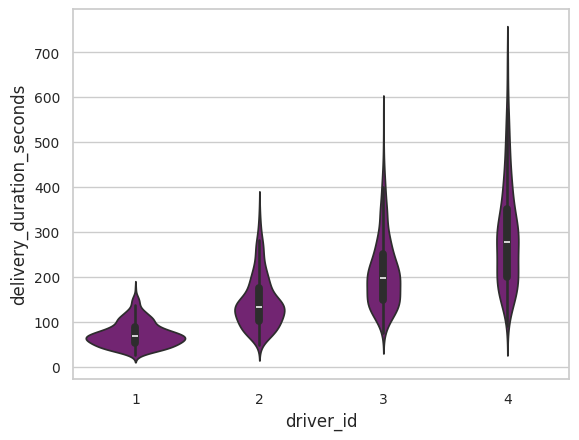

In [125]:
sns.violinplot(data=df, x='driver_id', y='delivery_duration_seconds')

/tmp/ipykernel_1401/1065979965.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_1401/1065979965.py:2: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  sns.violinplot(
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families w

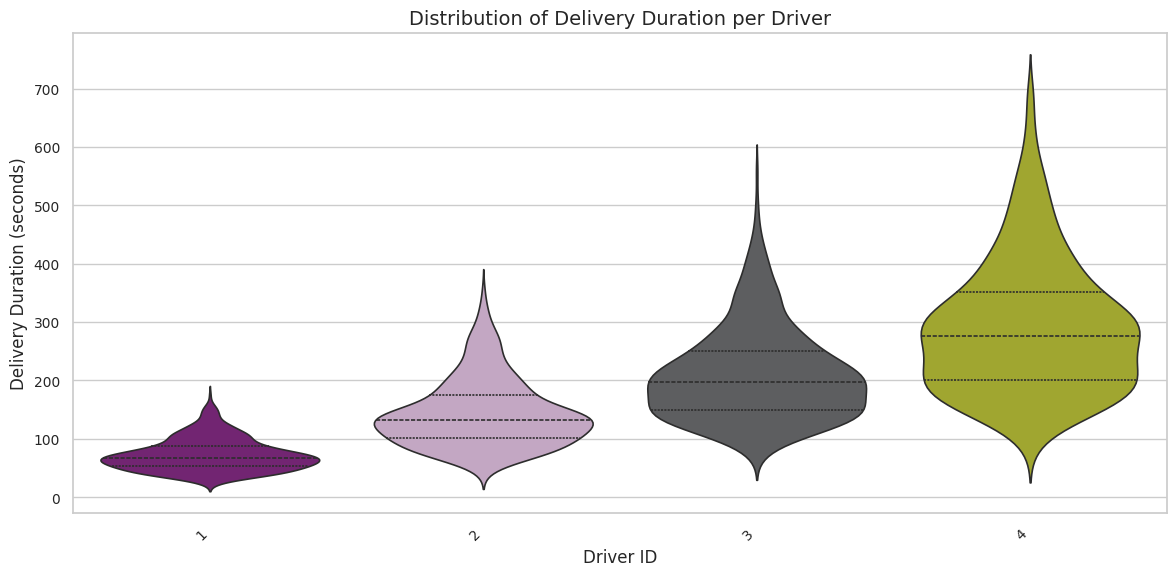

In [126]:
plt.figure(figsize=(12, 6))
sns.violinplot(
    data=df,
    x='driver_id',
    y='delivery_duration_seconds',
    palette=custom_palette,
    inner='quart',
    linewidth=1.2
)

plt.title('Distribution of Delivery Duration per Driver', fontsize=14)
plt.xlabel('Driver ID', fontsize=12)
plt.ylabel('Delivery Duration (seconds)', fontsize=12)

plt.xticks(rotation=45, ha='right')  # rotacja etykiet jeśli jest ich dużo
plt.tight_layout()
plt.show()

### Czy liczba produktów w zamówieniu wpływa na długość dostawy?

/tmp/ipykernel_1401/1297275787.py:2: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(data=df, x='total_quantity', y='delivery_duration_seconds', scale='width', inner='quartile')
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families

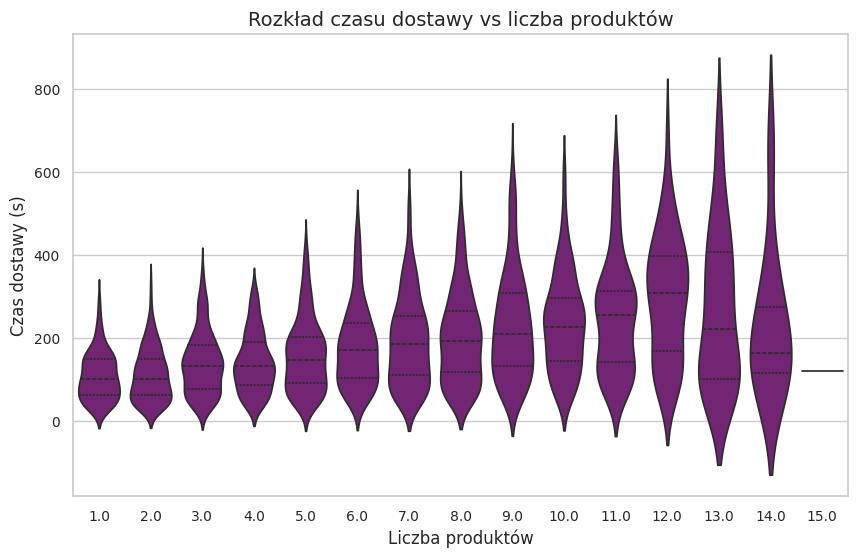

In [52]:
plt.figure(figsize=(10, 6))
sns.violinplot(data=df, x='total_quantity', y='delivery_duration_seconds', scale='width', inner='quartile')
plt.title('Rozkład czasu dostawy vs liczba produktów')
plt.xlabel('Liczba produktów')
plt.ylabel('Czas dostawy (s)')
plt.show()

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

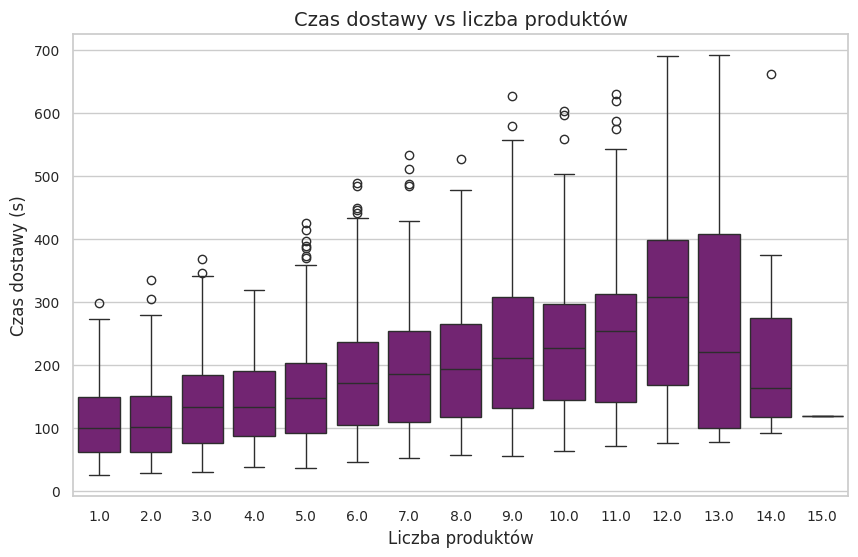

In [53]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='total_quantity', y='delivery_duration_seconds')
plt.title('Czas dostawy vs liczba produktów')
plt.xlabel('Liczba produktów')
plt.ylabel('Czas dostawy (s)')
plt.show()

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

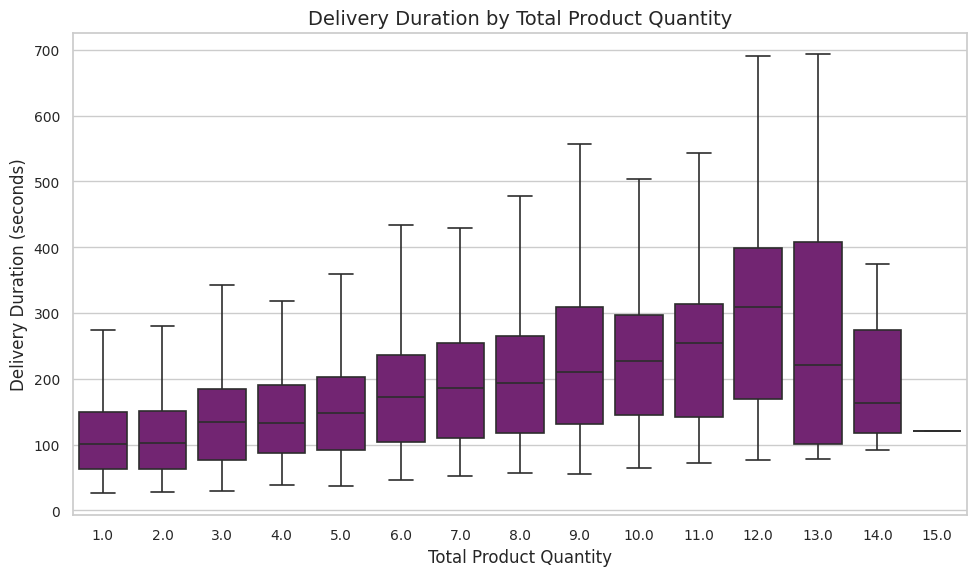

In [139]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df,
    x='total_quantity',
    y='delivery_duration_seconds',
    showfliers=False,
    color=custom_palette[0],  # Jeden, wybrany kolor
    linewidth=1.2
)

plt.title('Delivery Duration by Total Product Quantity', fontsize=14)
plt.xlabel('Total Product Quantity', fontsize=12)
plt.ylabel('Delivery Duration (seconds)', fontsize=12)

plt.tight_layout()
plt.show()

### Czy waga zamówienia wpływa na długość dostawy?

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

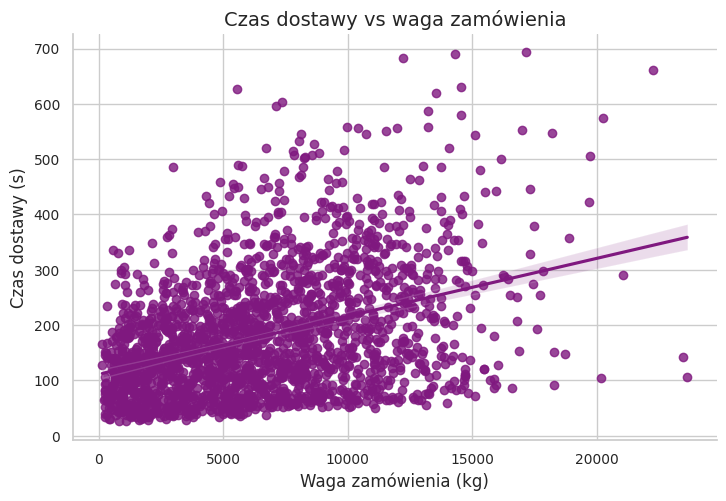

In [54]:
sns.lmplot(data=df, x='total_weight', y='delivery_duration_seconds', height=5, aspect=1.5)
plt.title('Czas dostawy vs waga zamówienia')
plt.xlabel('Waga zamówienia (kg)')
plt.ylabel('Czas dostawy (s)')
plt.show()

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

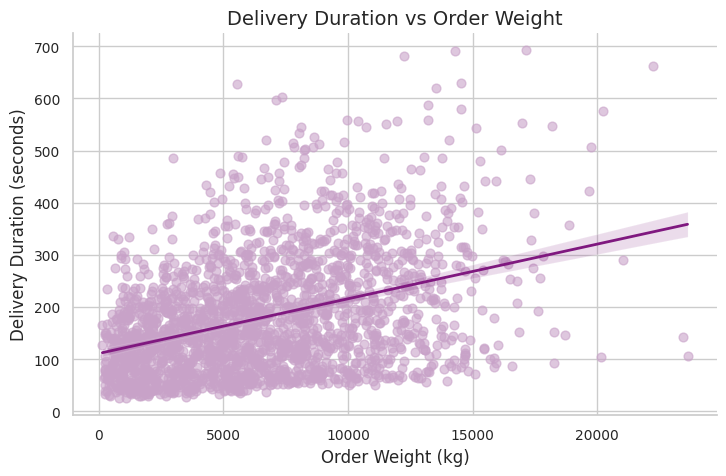

In [136]:
sns.lmplot(
    data=df,
    x='total_weight',
    y='delivery_duration_seconds',
    height=5,
    aspect=1.5,
    scatter_kws={'color': custom_palette[1], 'alpha': 0.6, 's': 40},  # kolor punktów
    line_kws={'color': custom_palette[0], 'linewidth': 2}  # kolor linii regresji
)

plt.title('Delivery Duration vs Order Weight', fontsize=14)
plt.xlabel('Order Weight (kg)', fontsize=12)
plt.ylabel('Delivery Duration (seconds)', fontsize=12)

plt.tight_layout()
plt.show()

### Czy pora dnia wpływa na długość dostawy?

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

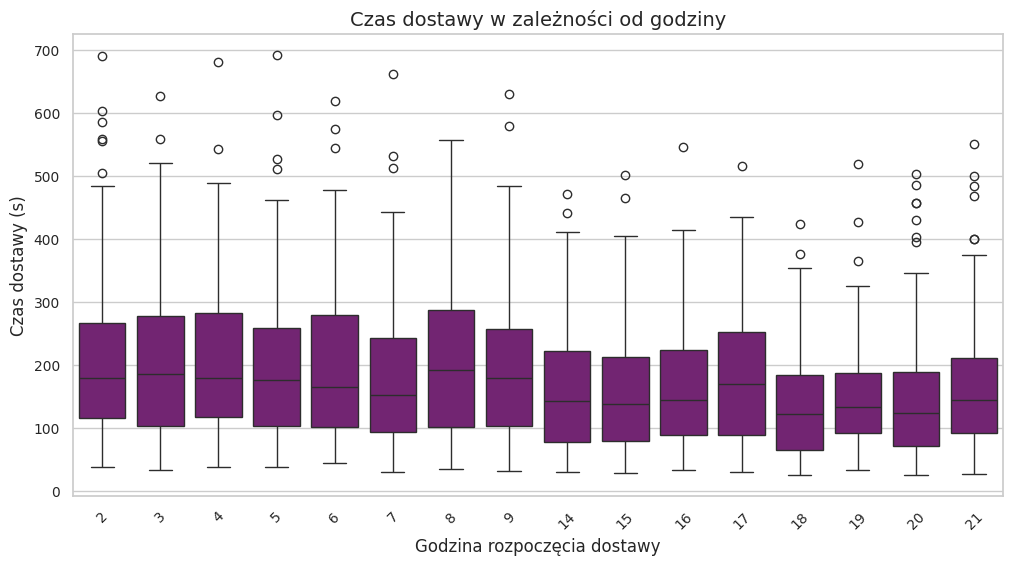

In [130]:
df['hour'] = pd.to_datetime(df['segment_start_time']).dt.hour
plt.figure(figsize=(12,6))
sns.boxplot(data=df, x='hour', y='delivery_duration_seconds')
plt.title('Czas dostawy w zależności od godziny')
plt.xlabel('Godzina rozpoczęcia dostawy')
plt.ylabel('Czas dostawy (s)')
plt.xticks(rotation=45)
plt.show()

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

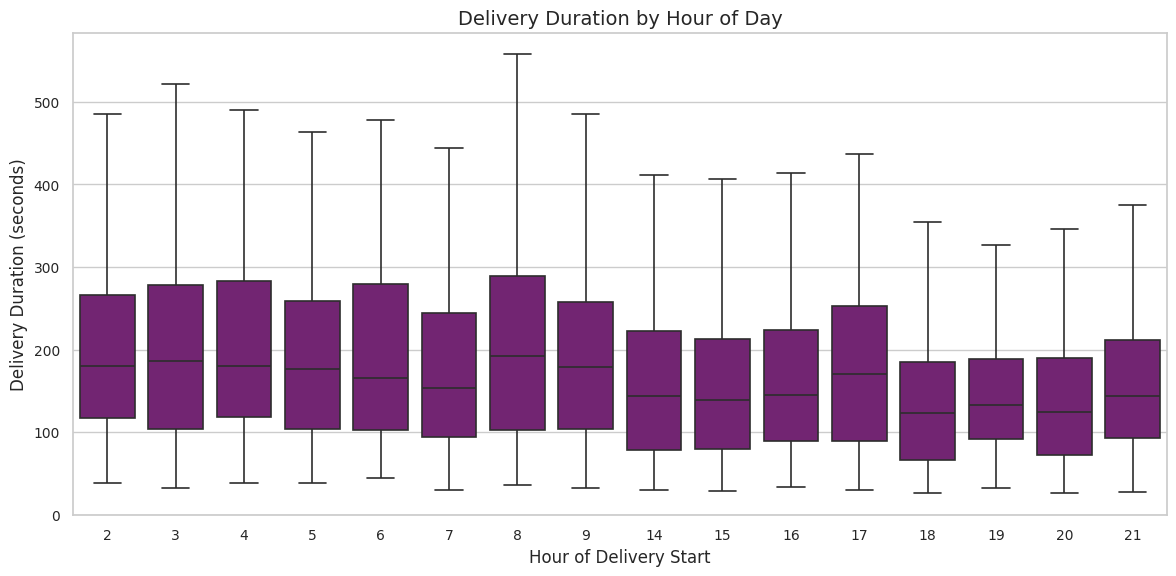

In [135]:
df['hour'] = pd.to_datetime(df['segment_start_time']).dt.hour

plt.figure(figsize=(12, 6))
sns.boxplot(
    data=df,
    x='hour',
    y='delivery_duration_seconds',
    showfliers=False,
    color=custom_palette[0],
    linewidth=1.2
)

plt.title('Delivery Duration by Hour of Day', fontsize=14)
plt.xlabel('Hour of Delivery Start', fontsize=12)
plt.ylabel('Delivery Duration (seconds)', fontsize=12)
plt.xticks(rotation=0)  # 24 godziny = lepiej bez rotacji

plt.tight_layout()
plt.show()

#### Czy dzień tygodnia wpływa na czas dostawy?

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

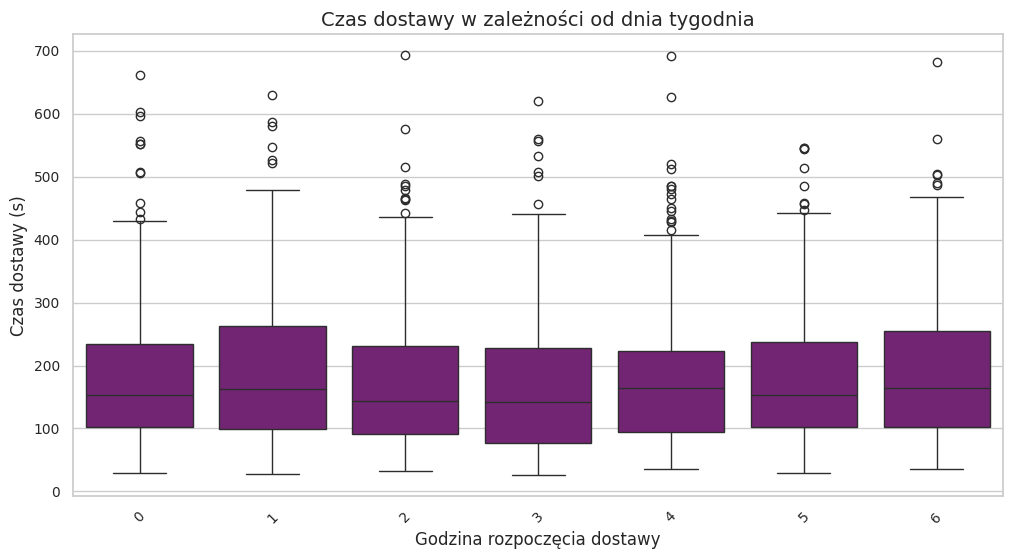

In [132]:
df['day_of_week'] = pd.to_datetime(df['segment_start_time']).dt.day_of_week
plt.figure(figsize=(12,6))
sns.boxplot(data=df, x='day_of_week', y='delivery_duration_seconds')
plt.title('Czas dostawy w zależności od dnia tygodnia')
plt.xlabel('Godzina rozpoczęcia dostawy')
plt.ylabel('Czas dostawy (s)')
plt.xticks(rotation=45)
plt.show()

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

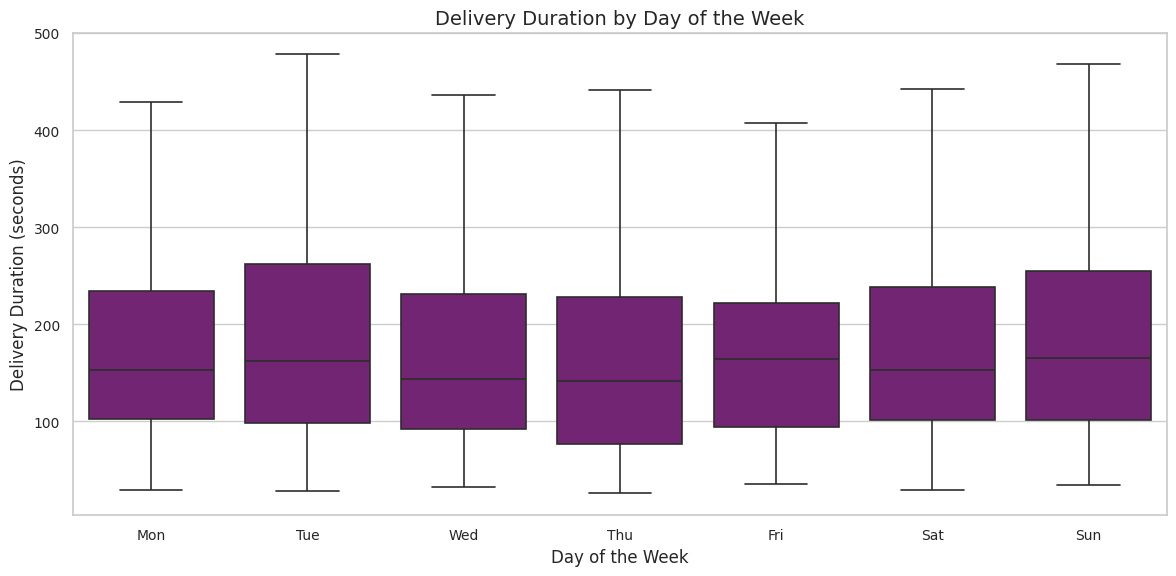

In [134]:
# Dodanie kolumny z nazwami dni tygodnia
df['day_of_week'] = pd.to_datetime(df['segment_start_time']).dt.dayofweek
day_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

plt.figure(figsize=(12, 6))
sns.boxplot(
    data=df,
    x='day_of_week',
    y='delivery_duration_seconds',
    showfliers=False,
    color=custom_palette[0],
    linewidth=1.2
)

# Ustawienie etykiet dni tygodnia
plt.xticks(ticks=range(7), labels=day_labels)

plt.title('Delivery Duration by Day of the Week', fontsize=14)
plt.xlabel('Day of the Week', fontsize=12)
plt.ylabel('Delivery Duration (seconds)', fontsize=12)

plt.tight_layout()
plt.show()

### Correlation

In [77]:
# Tabela korelacji
correlation_matrix = df.corr()

correlation_matrix

,order_id,delivery_duration_seconds,driver_id,segment_start_time,segment_end_time,total_quantity,total_weight,hour,day_of_week
order_id,1.000000,-0.019416,-0.040614,-0.010479,-0.010482,0.004062,0.014253,-0.008194,0.026378
delivery_duration_seconds,-0.019416,1.000000,0.725611,0.015174,0.015336,0.427144,0.378435,-0.183469,0.004557
driver_id,-0.040614,0.725611,1.000000,0.019908,0.020026,-0.006395,0.010700,-0.044431,0.004226
segment_start_time,-0.010479,0.015174,0.019908,1.000000,1.000000,-0.001391,0.011325,0.081117,-0.138410
segment_end_time,-0.010482,0.015336,0.020026,1.000000,1.000000,-0.001321,0.011387,0.081087,-0.138409
total_quantity,0.004062,0.427144,-0.006395,-0.001391,-0.001321,1.000000,0.851178,0.012727,-0.007903
total_weight,0.014253,0.378435,0.010700,0.011325,0.011387,0.851178,1.000000,0.024426,-0.004297
hour,-0.008194,-0.183469,-0.044431,0.081117,0.081087,0.012727,0.024426,1.000000,-0.025447
day_of_week,0.026378,0.004557,0.004226,-0.138410,-0.138409,-0.007903,-0.004297,-0.025447,1.000000


In [80]:


query = """
WITH delivery_durations as (
	SELECT *, TIMESTAMPDIFF(SECOND, segment_start_time, segment_end_time) AS delivery_duration_seconds
	FROM droptime.route_segments rs 
	WHERE rs.segment_type = 'STOP' and rs.order_id is not null and TIMESTAMPDIFF(SECOND, segment_start_time, segment_end_time) > 0
), statistics as (
	SELECT
		AVG(delivery_duration_seconds) AS Mean,
    	STDDEV(delivery_duration_seconds) AS StdDev
    FROM delivery_durations
), filtered_data as (
	SELECT *
	FROM delivery_durations dd
	CROSS JOIN statistics s
	WHERE dd.delivery_duration_seconds BETWEEN (s.Mean - 2 * s.StdDev) AND (s.Mean + 2 * s.StdDev)
), with_counts as (
	SELECT *, 
		ROW_NUMBER() OVER (PARTITION BY order_id ORDER BY delivery_duration_seconds) as rn
	FROM filtered_data
), dedup as (
	SELECT *		 
	FROM with_counts
	WHERE rn = 1
), data_with_errors as (
	SELECT d.order_id, o.sector_id, o.planned_delivery_duration, d.driver_id, d.segment_start_time, d.segment_end_time, d.delivery_duration_seconds - o.planned_delivery_duration as error, d.delivery_duration_seconds
	FROM dedup d
	LEFT JOIN droptime.orders o ON d.order_id = o.order_id
), order_product_data AS (
    SELECT 
        o.order_id,
        o.delivery_duration_seconds,
        op.product_id
    FROM data_with_errors o
    JOIN droptime.orders_products op ON o.order_id = op.order_id
)
SELECT * FROM order_product_data
 """

# query to pandas dataframe
df = pd.read_sql(query, engine)
df.head()

,order_id,delivery_duration_seconds,product_id
0,0,309,5
1,0,309,70
2,0,309,84
3,1,69,20
4,2,201,17


In [82]:
df["product_id"].value_counts()

product_id
86    82
39    78
89    78
91    77
45    76
      ..
56    49
6     49
75    49
34    48
90    43
Name: count, Length: 100, dtype: int64

<Axes: xlabel='product_id', ylabel='delivery_duration_seconds'>

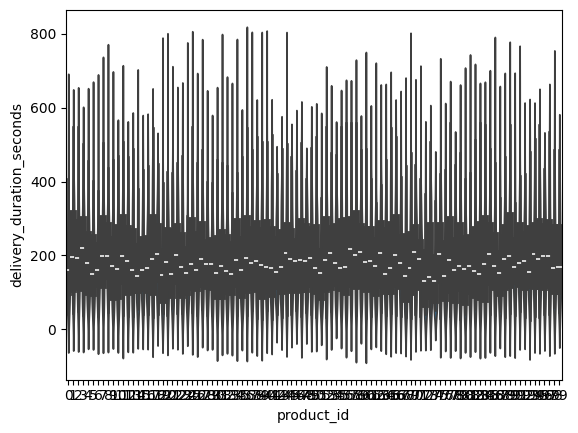

In [81]:
sns.violinplot(data=df, x='product_id', y='delivery_duration_seconds')

# Part 3. Building and verifying the hypothesis

Create a report in which you will briefly present your line of thinking. Write down assumptions you made, describe your methodology, e.g. how you filtered data etc. The report should be easy to understand for non-technical people. Name your report name_surname_research.pdf and include it as part of your final solution.

Don’t make any assumptions about data quality.

1.	The current prediction algorithm is very naive. It calculates the mean from all collected data and applies it to every future order. We need to explore alternative ideas. One of them is predicting delivery times per sector. Describe how you would validate this hypothesis using available data.
2.	Using the data, propose some alternative method/algorithm that will predict delivery times more accurately. Describe the methodology to validate the new algorithm.
3.	Why could some deliveries take more time? For example, some buildings don’t have elevators etc. Describe your ideas.
4.	What additional data would be worth collecting for future analysis of this domain?
5.	What is the risk of over- or under-estimating the delivery times?


## 1.	The current prediction algorithm is very naive. It calculates the mean from all collected data and applies it to every future order. We need to explore alternative ideas. One of them is predicting delivery times per sector. Describe how you would validate this hypothesis using available data.

Previous analyses have indeed shown that delivery times vary by sector. The simplest new algorithm would be to calculate the average for each sector separately and take it instead of the global one. Such an approach is still naive, but should have a positive effect on more accurate predictions.

To dispute whether such an approach makes sense, simply prepare new predictions for each order based on the average for each sector separately and then calculate the prediction errors. It is worth using measures such as MSE that will allow you to compare the two approaches with each other

In [61]:
query = """
-- dane potrzebne do znalezienia co może wpływać
WITH delivery_durations as (
	SELECT *, TIMESTAMPDIFF(SECOND, segment_start_time, segment_end_time) AS delivery_duration_seconds
	FROM droptime.route_segments rs 
	WHERE rs.segment_type = 'STOP' and rs.order_id is not null and TIMESTAMPDIFF(SECOND, segment_start_time, segment_end_time) > 0
), statistics as (
	SELECT
		AVG(delivery_duration_seconds) AS Mean,
    	STDDEV(delivery_duration_seconds) AS StdDev
    FROM delivery_durations
), filtered_data as (
	SELECT *
	FROM delivery_durations dd
	CROSS JOIN statistics s
	WHERE dd.delivery_duration_seconds BETWEEN (s.Mean - 2 * s.StdDev) AND (s.Mean + 2 * s.StdDev)
), with_counts as (
	SELECT *, 
		ROW_NUMBER() OVER (PARTITION BY order_id ORDER BY delivery_duration_seconds) as rn
	FROM filtered_data
), dedup as (
	SELECT *		 
	FROM with_counts
	WHERE rn = 1
), data_with_errors as (
	SELECT d.order_id, o.sector_id, o.planned_delivery_duration, d.driver_id, d.segment_start_time, d.segment_end_time, d.delivery_duration_seconds - o.planned_delivery_duration as error, d.delivery_duration_seconds
	FROM dedup d
	LEFT JOIN droptime.orders o ON d.order_id = o.order_id
) 
SELECT 
    o.order_id,
    o.sector_id,
    o.planned_delivery_duration,
    o.delivery_duration_seconds,
    o.driver_id,
    o.segment_start_time,
    o.segment_end_time,
    SUM(op.quantity) AS total_quantity,
    SUM(op.quantity * p.weight) AS total_weight
FROM 
    data_with_errors o
JOIN 
    droptime.orders_products op ON o.order_id = op.order_id
JOIN 
    droptime.products p ON op.product_id = p.product_id
GROUP BY 
    o.order_id,
    o.sector_id,
    o.planned_delivery_duration,
    o.delivery_duration_seconds,
    o.driver_id,
    o.segment_start_time,
    o.segment_end_time;
 """

# query to pandas dataframe
all_data = pd.read_sql(query, engine)
all_data.head()

,order_id,sector_id,planned_delivery_duration,delivery_duration_seconds,driver_id,segment_start_time,segment_end_time,total_quantity,total_weight
0,0,1,176,309,3,2024-02-04 08:34:03,2024-02-04 08:39:12,5.0,7793.0
1,1,1,169,69,1,2024-02-02 08:47:30,2024-02-02 08:48:39,3.0,5922.0
2,2,2,177,201,3,2024-02-15 07:11:54,2024-02-15 07:15:15,5.0,7742.0
3,3,3,176,92,1,2024-02-19 03:46:50,2024-02-19 03:48:22,12.0,18274.0
4,4,2,177,81,1,2024-02-21 14:43:38,2024-02-21 14:44:59,13.0,10208.0


In [63]:
sector_means = all_data.groupby('sector_id')['delivery_duration_seconds'].mean()
sector_means

sector_id
1    237.672515
2    151.470674
3    152.130374
Name: delivery_duration_seconds, dtype: float64

In [64]:
all_data["sector_based_predictions"] = all_data["sector_id"].map(sector_means)

In [65]:
all_data["errors"] = all_data["delivery_duration_seconds"] - all_data["planned_delivery_duration"]
all_data["sector_errors"] = all_data["delivery_duration_seconds"] - all_data["sector_based_predictions"]

In [66]:
all_data

,order_id,sector_id,planned_delivery_duration,delivery_duration_seconds,driver_id,segment_start_time,segment_end_time,total_quantity,total_weight,sector_based_predictions,errors,sector_errors
0,0,1,176,309,3,2024-02-04 08:34:03,2024-02-04 08:39:12,5.0,7793.0,237.672515,133,71.327485
1,1,1,169,69,1,2024-02-02 08:47:30,2024-02-02 08:48:39,3.0,5922.0,237.672515,-100,-168.672515
2,2,2,177,201,3,2024-02-15 07:11:54,2024-02-15 07:15:15,5.0,7742.0,151.470674,24,49.529326
3,3,3,176,92,1,2024-02-19 03:46:50,2024-02-19 03:48:22,12.0,18274.0,152.130374,-84,-60.130374
4,4,2,177,81,1,2024-02-21 14:43:38,2024-02-21 14:44:59,13.0,10208.0,151.470674,-96,-70.470674
...,...,...,...,...,...,...,...,...,...,...,...,...
2082,2235,3,175,358,4,2024-02-13 03:05:22,2024-02-13 03:11:20,11.0,18878.0,152.130374,183,205.869626
2083,2236,1,178,252,3,2024-02-25 14:13:17,2024-02-25 14:17:29,6.0,4863.0,237.672515,74,14.327485
2084,2237,2,177,74,1,2024-02-24 09:14:12,2024-02-24 09:15:26,8.0,9017.0,151.470674,-103,-77.470674
2085,2238,1,176,124,2,2024-02-12 15:59:57,2024-02-12 16:02:01,3.0,2283.0,237.672515,-52,-113.672515


#### Predictions based on global mean

In [67]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_squared_error
import numpy as np

# Actual vs predicted
y_true = all_data['delivery_duration_seconds']
y_pred = all_data['planned_delivery_duration']

# MAE
mae = mean_absolute_error(y_true, y_pred)

# RMSE
rmse = root_mean_squared_error(y_true, y_pred)

mse = mean_squared_error(y_true, y_pred)

print(f"MAE: {mae:.2f} seconds")
print(f"RMSE: {rmse:.2f} seconds")
print(f"MSE: {mse:.2f} seconds")

MAE: 87.24 seconds
RMSE: 111.72 seconds
MSE: 12480.67 seconds


<Axes: ylabel='Frequency'>

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

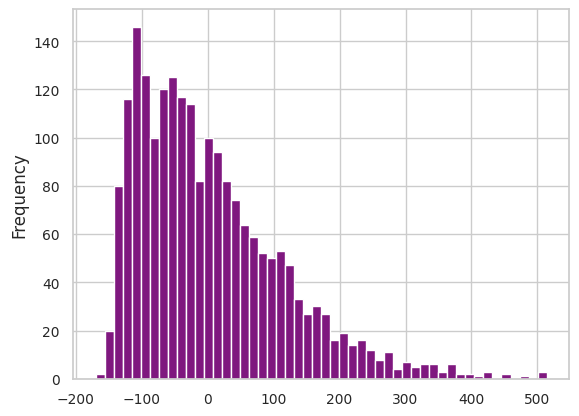

In [70]:
all_data["errors"].plot(kind="hist", bins=50)

#### predictions based on sectors mean

In [71]:
# Actual vs predicted
y_true = all_data['delivery_duration_seconds']
y_pred = all_data['sector_based_predictions']

# MAE
mae = mean_absolute_error(y_true, y_pred)

# RMSE
rmse = root_mean_squared_error(y_true, y_pred)

mse = mean_squared_error(y_true, y_pred)

print(f"MAE: {mae:.2f} seconds")
print(f"RMSE: {rmse:.2f} seconds")
print(f"MSE: {mse:.2f} seconds")

MAE: 82.10 seconds
RMSE: 103.90 seconds
MSE: 10794.52 seconds


<Axes: ylabel='Frequency'>

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

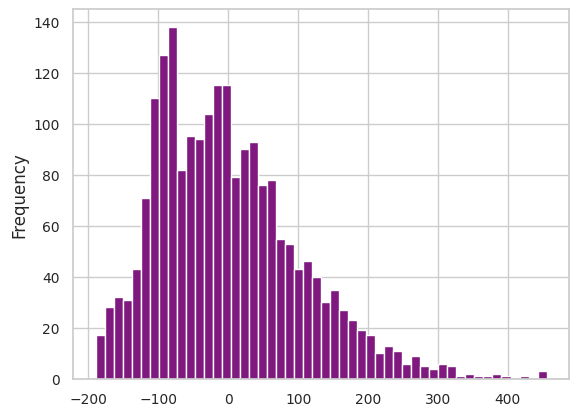

In [72]:
all_data["sector_errors"].plot(kind="hist", bins=50)

As we can see, a simple experiment indicated that the approach based on predictions of average time from each sector allowed for slightly better predictions as confirmed by the MSE, MAE, RMSE measures used

## 2.	Using the data, propose some alternative method/algorithm that will predict delivery times more accurately. Describe the methodology to validate the new algorithm.

Of course, the methods can be many, ranging from self-created algorithms based on statistics and observations to the use of learning machine models. The problem under study is a typical example of a regression task, when on the basis of several factors, such as the weight of the shipment, the number of products in the shipment, the sector of the city, we want to predict the values here - delivery time. You can use models based on linear regression, polynomial regression, SVM, or, for example, random forests. My recommendation is to choose random forest as an ingenious base model, which will not only help you get better predictions, but in addition, it has high interpetability, so it is easier for us to understand the overall problem as well as each prediction individually.

To test how the new algorithm will perform, it is necessary to divide the data into a training set and a test set. The data from the training set will be used to learn the model for predicting delivery times, while the test data will allow us to test the model on previously unseen data. And in this case, we will re-run the prediction for each order from osbna and compare it with the true values, using, for example, the MSE


In [12]:
# potrzebuję tabelę z kilkoma cechami oraz prawdziwymi czasami dostawy
# następnie dane te muszę podzielić na treningowe i testowe
# zbuduj model 
# sprawdź feture importance itp
# walidacja modelu

In [73]:
all_data["day_of_week"] = pd.to_datetime(all_data['segment_start_time']).dt.day_of_week
all_data["hour"] = pd.to_datetime(all_data['segment_start_time']).dt.hour

In [74]:
all_data.head()

,order_id,sector_id,planned_delivery_duration,delivery_duration_seconds,driver_id,segment_start_time,segment_end_time,total_quantity,total_weight,sector_based_predictions,errors,sector_errors,day_of_week,hour
0,0,1,176,309,3,2024-02-04 08:34:03,2024-02-04 08:39:12,5.0,7793.0,237.672515,133,71.327485,6,8
1,1,1,169,69,1,2024-02-02 08:47:30,2024-02-02 08:48:39,3.0,5922.0,237.672515,-100,-168.672515,4,8
2,2,2,177,201,3,2024-02-15 07:11:54,2024-02-15 07:15:15,5.0,7742.0,151.470674,24,49.529326,3,7
3,3,3,176,92,1,2024-02-19 03:46:50,2024-02-19 03:48:22,12.0,18274.0,152.130374,-84,-60.130374,0,3
4,4,2,177,81,1,2024-02-21 14:43:38,2024-02-21 14:44:59,13.0,10208.0,151.470674,-96,-70.470674,2,14


#### Zrób równierz wersję bez driver_id
* być może wymyśl jeszcze jakieś cechy
* być może dodaj cross val
* napewno porónaj wyniki do poprzednich podejść

In [92]:
# Przykład: wybór kolumn
features = ['sector_id', "day_of_week", "hour", "total_quantity", "total_weight", "driver_id"]
target = 'delivery_duration_seconds'

X = all_data[features]
y = all_data[target]

In [93]:
X = pd.get_dummies(X, columns=['sector_id', 'day_of_week'], drop_first=True)

In [94]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

In [95]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [96]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"MAE: {mae:.2f} seconds")
print(f"RMSE: {rmse:.2f} seconds")
print(f"MSE: {mse:.2f} seconds")

MAE: 14.95 seconds
RMSE: 21.71 seconds
MSE: 471.22 seconds


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

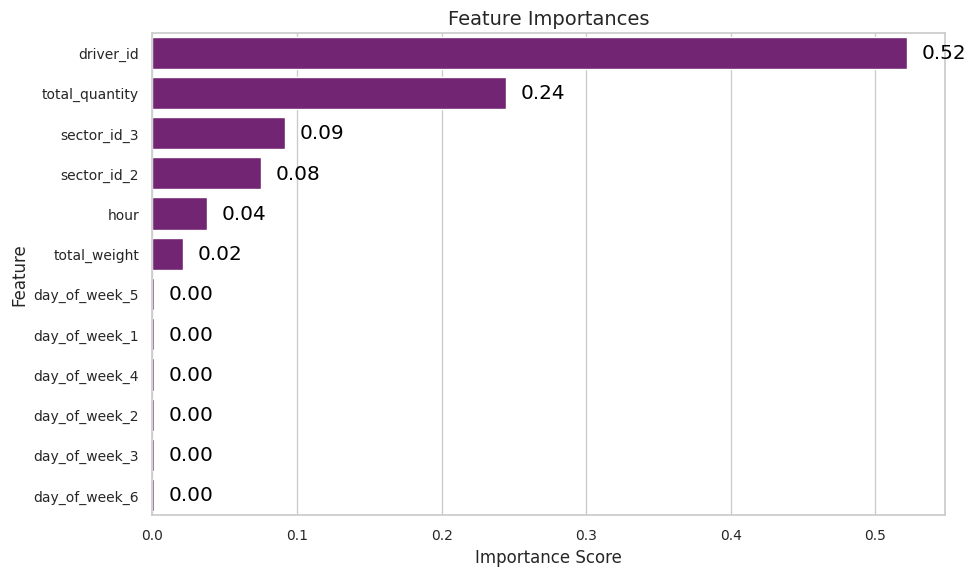

In [99]:
import matplotlib.pyplot as plt
import seaborn as sns

feature_importances = pd.Series(model.feature_importances_, index=X.columns)
feature_importances = feature_importances.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=feature_importances.values, y=feature_importances.index)

# Dodanie wartości na słupkach
for i, v in enumerate(feature_importances.values):
    ax.text(v + 0.01, i, f"{v:.2f}", color='black', va='center')

# Tytuł i opisy osi
plt.title('Feature Importances', fontsize=14)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)

plt.tight_layout()
plt.show()

In [81]:
e = y_test - y_pred

(array([ 1.,  0.,  0.,  2.,  0.,  2.,  0.,  3.,  3.,  7., 16.,  6., 12.,
        13., 20., 25., 25., 55., 64., 74., 74., 54., 37., 26., 25., 18.,
        14.,  6.,  2., 10.,  4.,  4.,  5.,  6.,  3.,  5.,  0.,  2.,  1.,
         0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.]),
 array([-77.46 , -73.555, -69.65 , -65.745, -61.84 , -57.935, -54.03 ,
        -50.125, -46.22 , -42.315, -38.41 , -34.505, -30.6  , -26.695,
        -22.79 , -18.885, -14.98 , -11.075,  -7.17 ,  -3.265,   0.64 ,
          4.545,   8.45 ,  12.355,  16.26 ,  20.165,  24.07 ,  27.975,
         31.88 ,  35.785,  39.69 ,  43.595,  47.5  ,  51.405,  55.31 ,
         59.215,  63.12 ,  67.025,  70.93 ,  74.835,  78.74 ,  82.645,
         86.55 ,  90.455,  94.36 ,  98.265, 102.17 , 106.075, 109.98 ,
        113.885, 117.79 ]),
 <BarContainer object of 50 artists>)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

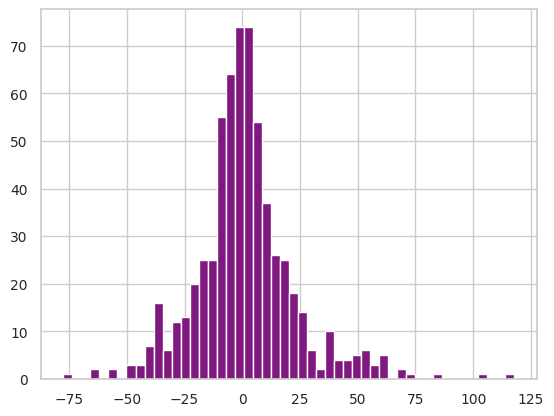

In [82]:
plt.hist(e, bins=50)

In [83]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_pred = all_data["planned_delivery_duration"].loc[X_test.index]

mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"MAE: {mae:.2f} seconds")
print(f"RMSE: {rmse:.2f} seconds")
print(f"MSE: {mse:.2f} seconds")

MAE: 86.26 seconds
RMSE: 108.93 seconds
MSE: 11866.08 seconds


In [84]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_pred = all_data["sector_based_predictions"].loc[X_test.index]

mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"MAE: {mae:.2f} seconds")
print(f"RMSE: {rmse:.2f} seconds")
print(f"MSE: {mse:.2f} seconds")

MAE: 80.80 seconds
RMSE: 100.58 seconds
MSE: 10116.87 seconds


#### Model without driver id

In [103]:
# Przykład: wybór kolumn
features = ['sector_id', "day_of_week", "hour", "total_quantity", "total_weight"]
target = 'delivery_duration_seconds'

X = all_data[features]
y = all_data[target]

X = pd.get_dummies(X, columns=['sector_id', 'day_of_week'], drop_first=True)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)





RandomForestRegressor(random_state=42)

In [104]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"MAE: {mae:.2f} seconds")
print(f"RMSE: {rmse:.2f} seconds")
print(f"MSE: {mse:.2f} seconds")

MAE: 72.42 seconds
RMSE: 90.86 seconds
MSE: 8255.93 seconds


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

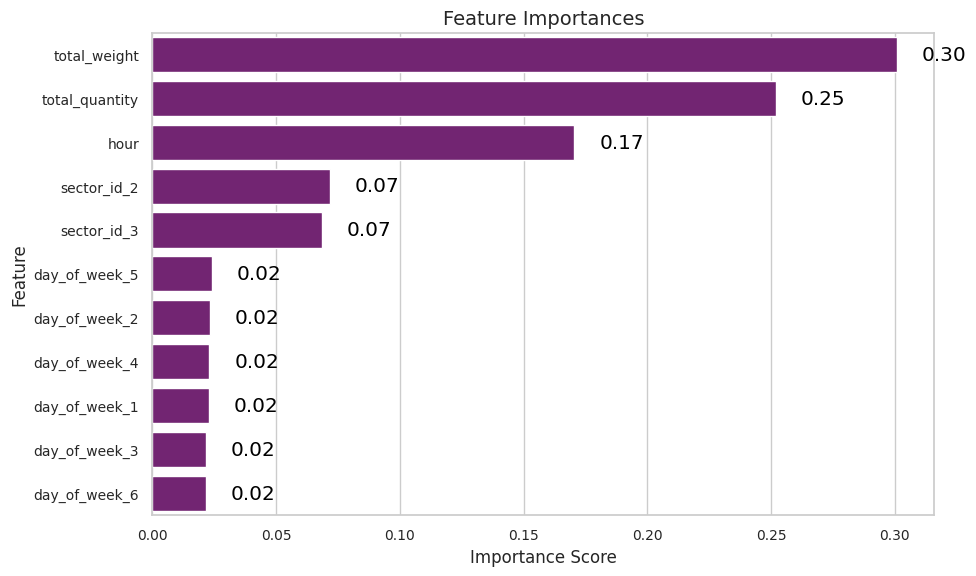

In [105]:
feature_importances = pd.Series(model.feature_importances_, index=X.columns)
feature_importances = feature_importances.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=feature_importances.values, y=feature_importances.index)

# Dodanie wartości na słupkach
for i, v in enumerate(feature_importances.values):
    ax.text(v + 0.01, i, f"{v:.2f}", color='black', va='center')

# Tytuł i opisy osi
plt.title('Feature Importances', fontsize=14)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)

plt.tight_layout()
plt.show()

In [88]:
e = y_test - y_pred

(array([ 1.,  0.,  1.,  3.,  1.,  2.,  2.,  7.,  4.,  8., 13.,  8., 11.,
        19., 19., 28., 19., 30., 24., 26., 35., 32., 22., 35., 18., 31.,
        36., 34., 26., 25., 21., 16.,  8., 10.,  6.,  8.,  5.,  8.,  5.,
         3.,  4.,  4.,  1.,  3.,  1.,  0.,  1.,  1.,  0.,  2.]),
 array([-260.3   , -249.0132, -237.7264, -226.4396, -215.1528, -203.866 ,
        -192.5792, -181.2924, -170.0056, -158.7188, -147.432 , -136.1452,
        -124.8584, -113.5716, -102.2848,  -90.998 ,  -79.7112,  -68.4244,
         -57.1376,  -45.8508,  -34.564 ,  -23.2772,  -11.9904,   -0.7036,
          10.5832,   21.87  ,   33.1568,   44.4436,   55.7304,   67.0172,
          78.304 ,   89.5908,  100.8776,  112.1644,  123.4512,  134.738 ,
         146.0248,  157.3116,  168.5984,  179.8852,  191.172 ,  202.4588,
         213.7456,  225.0324,  236.3192,  247.606 ,  258.8928,  270.1796,
         281.4664,  292.7532,  304.04  ]),
 <BarContainer object of 50 artists>)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

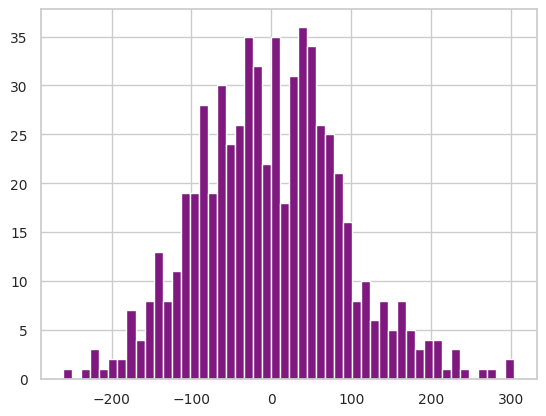

In [89]:
plt.hist(e, bins=50)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

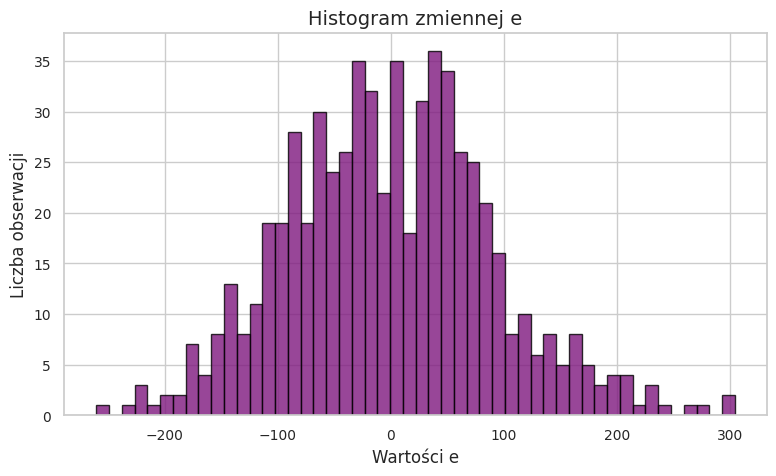

In [91]:
plt.figure(figsize=(8, 5))
plt.hist(e, bins=50, color=custom_palette[0], edgecolor='black', alpha=0.8)

plt.title('Histogram zmiennej e', fontsize=14)
plt.xlabel('Wartości e', fontsize=12)
plt.ylabel('Liczba obserwacji', fontsize=12)

plt.grid(True)
plt.tight_layout()
plt.show()

## 3.	Why could some deliveries take more time? For example, some buildings don’t have elevators etc. Describe your ideas.

* zmęczenie pracownika, istnieje prawdopodobieństwo że wraz z kolejnymi godzinami pracy pracownika jego wydajność może spadać
* ilość produktów w zamówienia wraz z powiązaniem wagi tych produktów. Prawdopodobnie łatwiej i szybciej jest dostarczyć przesyłkę skłądającą się z jednego czy kilku małych i lekkich produktów w porównaniu do zamówień produktów ciężkich i większej ich ilości
* Typ budynków rónierz może na to wpływać. Prawdopodobnie dostarczenie przesyłki do mieszkania w bloku na jakimś osiedlu może trwać dłużej w porównaniu do typowego domu jednorodzinnego. Składać się na to może trudność w zanelzieniu konkretnego mieszkania, większe odległości od miejsca zaparkowania, konieczność udania się na odpowienie piętro w budunku, tym bardziej, że w niektórych może np. brakować windy
* pogoda
* dzień tygodnia? trochę na siłę chyba

## 4.	What additional data would be worth collecting for future analysis of this domain?

* typ budynku
* czy jest winda
* pogoda
* dane o dostawcy, być może jak jest doświadczony, wiek
* rozmiar przesyłek, czy przesyłka składa się z jednej części czy wielu, czy są one łatwe w przeniesieniu

## 5.	What is the risk of over- or under-estimating the delivery times?

Przypadek przeszacowania czasu dostawy wydaje się być obiektywnie mniej dotkliwy. Jest to przypadek gdy faktyczna dostawa potrwa krócej niż mówi predykcja. Klient prawdopodobnie będzie zadowolony, że daną przesyłkę dostał szybciej. Oczywiście ma to równierz swoje minusy w postaci gorszej optymalizacji, łańcucha dostaw. (mogą być sytuacje że dostawcy nie będą optymalnie wykorzystywani w stodunku do ich możliwości) Być może, równierz w niektórych przypadkach może to odstraszyć użytkownika podczas składania zamówinia (jeżeli taka informacja się mu wyświetla)

Nie doszacowanie czasu dostawy wydaje się mieć większe negatywne konsekwencje. Zaczynając od niezadowolenia klientów za spóźnienia. Po sam łańcuch dostaw. System w takim przypadku może zlecać zby dużą liczbę dostaw na jednego kuriera, oni z kolei mogą z tymi dostawami nie wyrabiać, koniecznym może być robienie nadgodzin, lub w ekstemalnych przypadkach problemy z niektórymi dostawami.